# Kinetics VI

This lecture covers the analysis differential tubular reactors (plug flow or packed bed reactors). We will consider the origin of "non-elementary" or non-power law kinetics observed during Azomethane decomposition. This will transition into analysis of reaction mechanisms and elementary steps.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

Azomethane decomposition is carried out in a 50 mL Plug Flow Reactor that is operating under differential conditions at steady state. The reaction is given below:

$$C_2H_6N_2 \longrightarrow C_2H_6 + N_2$$

Azomethane decomposition is thermodynamically very favorable, so you can assume the reaction is irreversible.  For convenience, we will just relabel everything as:

$$A \longrightarrow B + C$$

For this experiment, you vary the feed concentration while maintaining a very high volumetric flowrate (your space time approaches zero). This ensures the fractional conversion of $A$, $X_A$, stays well below 1\% for all experiments. At each unique feed concentration, you measure the concentration of species $B$ in the reactor effluent and use it to determine the effluent molar flowrate of species $B$. Collected data are compiled in the table below. 

| $C_{Af} \ (\mathrm{mmol \ L^{-1}})$| $F_B (\mathrm{mmol \ min^{-1}})$| 
|:----------------------------------:|:-------------------------------:|
| $0.001$                            | $2.45 \times 10^{-9}$           |
| $0.002$                            | $9.08 \times 10^{-9}$           |
| $0.005$                            | $6.29 \times 10^{-8}$           |
| $0.01$                             | $2.27 \times 10^{-7}$           |
| $0.02$                             | $9.50 \times 10^{-7}$           |
| $0.05$                             | $5.39 \times 10^{-6}$           |
| $0.10$                             | $2.05 \times 10^{-5}$           |
| $0.20$                             | $5.72 \times 10^{-5}$           |
| $0.50$                             | $2.43 \times 10^{-4}$           |
| $1.0$                              | $6.71 \times 10^{-4}$           |
| $2.0$                              | $1.56 \times 10^{-3}$           |
| $5.0$                              | $4.25 \times 10^{-3}$           |
| $10.0$                             | $7.43 \times 10^{-3}$           |
| $20.0$                             | $1.70 \times 10^{-2}$           |
| $50.0$                             | $3.98 \times 10^{-2}$           |
| $100.0$                            | $7.99 \times 10^{-2}$           |

Use the measured concentrations of $A$ in the reactor effluent to determine the reaction order in $A$ and the rate constant for this reaction.

In [3]:
V  = 0.050 #L
CA_exp = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]) #mmol/L
FB_exp = np.array([2.01E-09, 1.09E-08, 5.98E-08, 2.53E-07, 9.75E-07, 5.84E-06, 1.82E-05, 6.89E-05, 2.03E-04, 5.23E-04, 1.60E-03, 3.75E-03, 8.40E-03, 1.49E-02, 4.52E-02, 7.10E-02]) #mmol/min

### Solution to Example Problem 01

A differential tubular reactor is a bit of a different concept than what we've covered so far.  The idea is that you operate the reactor so close to 0% conversion that the composition is constant across the reactor.  We also generally would operate a differential reactor in such a way that the change in temperature and pressure across the reactor is neglible.  This is important because we generally expect that reaction rate depends on temperature, pressure, and composition. If these three things are constant across the reactor Volume (or catalyst bed), then the reaction rate is also constant spatially across the entire length of the reactor. We start our analysis by writing a material balance on the tubular reactor. In this case, it is a PFR:

$$\frac{dF_A}{dV} = R_A$$

We have a single reaction with a coefficient of -1 on A, so $R_A = -r$.

$$\frac{dF_A}{dV} = -r$$

As usual, we find that the derivative of molar flowrate with respect to volume would give us the reaction rate.  In this specific case of a differential reactor, we take advantage of the fact that the rate is constant with respect to reactor volume. Separating variables, we get:

$$dF_A = -rdV$$

We want to integrate this from inlet to outlet of the PFR:

$$\int_{F_{A,f}}^{F_A} dF_A = \int_0^V-rdV$$

Here, we take advantage of the fact that the rate is constant, so it is independent of volume:

$$\int_{F_{A,f}}^{F_A} dF_A = -r\int_0^VdV$$

So this equation becomes easy to solve.  We find:

$$F_{A} - F_{A,f} = -rV$$

Solving for $r$:

$$r = \frac{F_{A,f} - F_A}{V}$$

In other words, if we take the difference between the feed and exit molar flowrate of A, and we divide it by the volume of the reactor, we get an exact value of the reaction rate at the relevant concentration, temperature, and pressure at the reactor inlet. Note that if fluid density is constant, which it almost certainly is in a differential tubular reactor, then the following is also true.  

$$r = \frac{C_{A,f} - C_A}{\tau}$$

For both of the above expressions, you should see that they are identical to CSTR balances.  This is correct -- if we are operating a tubular reactor in such a way that the composition, temperature, and pressure are invariant across the reactor, then it is functioning exactly like a well-mixed flow reactor and the balance becomes a CSTR balance! We have a problem here, though, because as $X_A \rightarrow 0$, we know that $F_A \rightarrow F_{A,f}$ and $C_F \rightarrow C_{A,f}$. This limits on our ability to measure precise concentrations and flowrates will create serious problems in rate estimates at the zero conversion limit. We encountered this already in [Notebook 43](https://jqbond.github.io/CEN587/Notebooks/587-N43.html) when analyzing CSTR data obtained at very short values of $\tau$, where conversion was nearly 0%. As in the CSTR analysis, our solution here is to focus define rates in terms of product formation instead of in terms of reactant consumption.

#### Use Product Flowrates to estimate rate

Usually, our precision in quantifying the molar flowrate of the reactant (species $A$) coming out of the differential reactor is, at best, $\pm 5\%$. That means the difference between the feed and exit flowrate of $A$ is within our precision limits, and we get very noisy estimates of reaction rates if we try to quantify things this way. As we saw in [Notebook 43](https://jqbond.github.io/CEN587/Notebooks/587-N43.html), when reactors are operated such that reactant conversion approaches zero, the better approach is to use reaction product measurements to estimate the rate of reaction. We start by writing a balance on a product instead of on a reactant:

$$\frac{dF_B}{dV} = R_B$$

For a single reaction where species $B$ has a coefficient of 1:

$$\frac{dF_B}{dV} = r$$

We'll separate this ODE and integrate over the appropriate limits:

$$\int_{F_{B,f}}^{F_B}dF_B = \int_0^VrdV$$

Again, we know that rate is not changing over the reactor volume, so r is a constant in this case.  This allows the following simplification:

$$\int_{F_{B,f}}^{F_B}dF_B = r\int_0^VdV$$

Which makes the integration pretty straightforward.  We ultimately get:

$$F_B - F_{B,f} = rV$$

We know that there is no species $B$ coming into the reactor, so $F_{B,f} = 0$.  We then solve for r:

$$r = \frac{F_B}{V}$$

Again, since fluid density is almost certainly constant in a differential flow reactor, we can write express the above in terms of concentration and space time.

$$r = \frac{C_B}{\tau}$$

This is really a useful result, and we again see balances that are equivalent to the CSTR result!  It means that estimating the reaction rate just requires us to measure the flowrate of product coming out of the reactor and divide it by the reactor volume. That's the approach we'll use below. Importantly, when we base our rate estimates off of product formation, we do not have to worry about the issues that arise when we subtract two imprecise numbers that are nearly identical (e.g., $F_{A,f} - F_A$)

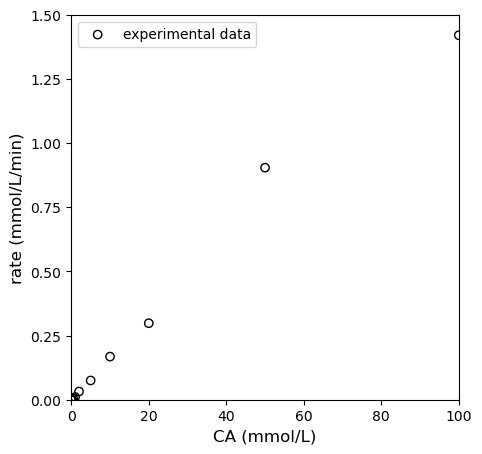

In [4]:
##############################################################################################
# Calculate reaction rates for each experiment using the differential reactor result         #
##############################################################################################

r_exp = FB_exp/V #mol/L/min

##############################################################################################
# Plot reaction rates as a function of CA to assess reaction order in A                      #
##############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CA_exp, r_exp, color = 'none', edgecolor = 'black', marker = 'o', label = 'experimental data')
plt.xlabel('CA (mmol/L)', fontsize = 12)
plt.ylabel('rate (mmol/L/min)', fontsize = 12)
plt.xlim(0, 100)
plt.ylim(0, 1.5)
plt.yticks(np.arange(0, 1.6, 0.25))
plt.legend(loc = 'upper left')
plt.show()

#### Linearization of data

Now we have estimates of the reaction rate for various values of feed concentration of $A$.  Since we are operating the reactor at very low conversion, we know that the concentration of $A$ throughout the reactor is approximately equal to the feed concentration of $A$.  Thus, we have a set of rates at a representative set of concentrations of the reactant. Our aim is to determine the reaction order in $A$ as well as the rate constant. We might propose that this reaction follows power law kinetics as usual:

$$r = k \, {C_A}^\alpha$$

This can be linearized using a logarithmic transformation:

$$\ln(r) = \ln(k) + \alpha \ln(C_A)$$

We then plot $\ln(r)$ vs. $\ln(C_A)$ to assess linearity and regress the slope, $\alpha$, and y-intercept, $\ln(k)$...

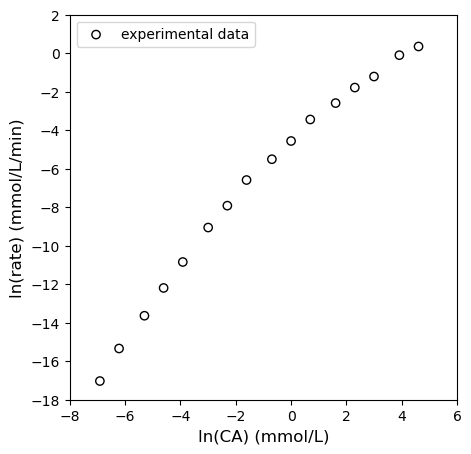

In [5]:
#############################################################################
# Attempt power law linearization of rate vs. CA data                       #
#############################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CA_exp), np.log(r_exp), color = 'none', edgecolor = 'black', marker = 'o', label = 'experimental data')
plt.xlabel('ln(CA) (mmol/L)', fontsize = 12)
plt.ylabel('ln(rate) (mmol/L/min)', fontsize = 12)
plt.xlim(-8, 6)
plt.ylim(-18, 2)
plt.yticks(np.arange(-18, 3, 2))
plt.legend(loc = 'upper left')
plt.show()

#### Linear Regression to estimate $\alpha$ and k

The log transformed data above doesn't really look very linear, but let's go ahead and regress the best fit line, estimate parameters, and calculate relevant statistics to provide a more quantitative assessment.

m    =  1.50e+00 +/- 1.23e-01
b    = -5.23e+00 +/- 4.59e-01
SSE  =      9.28
SST  =    463.79
MSE  =      0.58
RMSE =      0.76
R2   =      0.98
α    =  1.50e+00 +/- 1.23e-01
k    =  5.33e-03 (but is between 3.37e-03 and 8.44e-03)


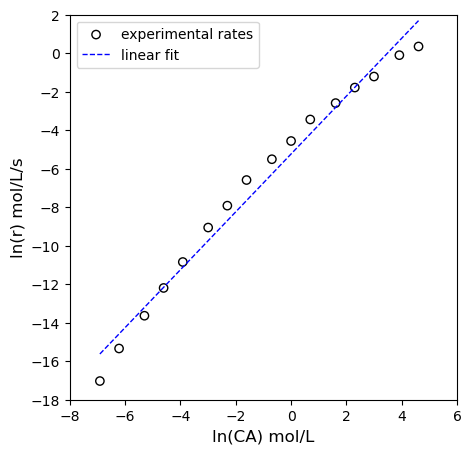

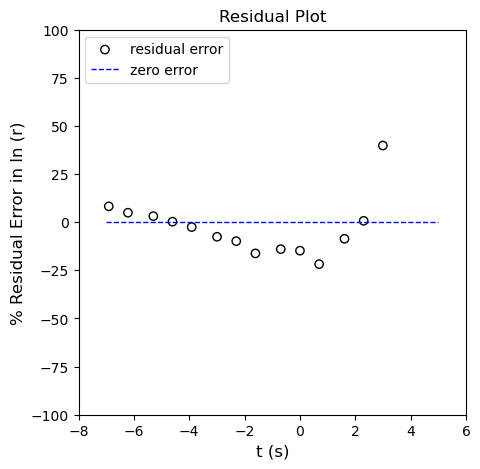

In [11]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(r_exp)
xdata = np.log(CA_exp)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(-8.0, 6)
plt.ylim(-18.0, 2.0)
plt.yticks(np.arange(-18, 3, 2))
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(-8, 6)
plt.ylim(-100, 100)
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()

#### A closer look

OK, there are some problems here.  While the R2 value isn't bad, we see clear systematic deviation instead of data points scattered randomly around the line of best fit.  This suggests that our power law model is not correct.  Furthermore, we get a "best fit" reaction order of 1.5, which is a bit strange.  Let's take a closer look!  

If you focus only on data obtained at low concentration, we see linearity. Similarly, at very high concentrations, we see linearity again.  This suggests power law kinetics hold at very low and very high concentrations of $A$, it's just that the value of the reaction order, $\alpha$, is different in each concentration regime. We will fit a line to the 4 lowest concentration measurements and the 4 highest concentration measurements to assess reaction orders in each limit. These regressed lines are added to the plot of experimental data.

The regressed order at low CA is 2.095
The regressed order at high CA is 0.966


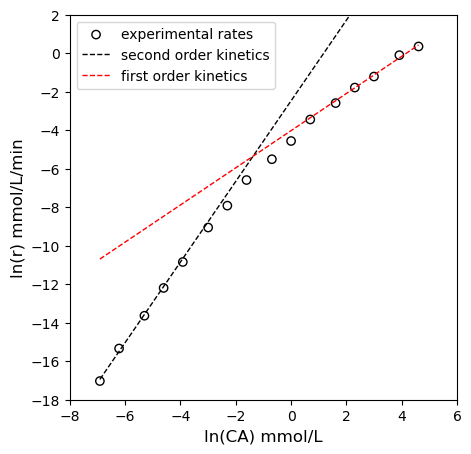

In [13]:
Y      = np.log(r_exp)
X      = np.vander(np.log(CA_exp), 2)
Alow  = np.linalg.solve(X[0:3,:].T@X[0:3,:], X[0:3,:].T@Y[0:3]) #regression coefficients, slope and intercept
Ahigh = np.linalg.solve(X[-4:,:].T@X[-4:,:], X[-4:,:].T@Y[-4:]) #regression coefficients, slope and intercept
Yplow = X@Alow
Yphigh = X@Ahigh

print(f'The regressed order at low CA is {Alow[0]:3.3f}')
print(f'The regressed order at high CA is {Ahigh[0]:3.3f}')
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(np.log(CA_exp), Yplow, color = 'black', linestyle = 'dashed', linewidth = 1, label = 'second order kinetics')
plt.plot(np.log(CA_exp), Yphigh, color = 'red', linestyle = 'dashed', linewidth = 1, label = 'first order kinetics')
plt.xlabel('ln(CA) mmol/L', fontsize = 12)
plt.ylabel('ln(r) mmol/L/min', fontsize = 12)
plt.xlim(-8, 6)
plt.ylim(-18, 2)
plt.yticks(np.arange(-18, 3, 2))
plt.legend()
plt.show()

This confirms that we see different reaction orders in different concentration regimes -- this means that the the observed reaction order changes depending on where we measure the reaction rate. If we make measurements at very low concentrations of $A$, the rate is second order in $A$.  If we make measurements at very high concentrations of $A$, the rate is first order in $A$. The reason for this is that Azomethane decomposition (and almost every other reaction we might study in the lab) is an ***overall*** reaction. The balanced equation for azomethane decomposition describes the stoichiometric changes between observable reactants and products, but it does not describe the bond breaking and bond forming events that comprise the chemical transformations. In other words, azomethane decomposition as written above is not an elementary step.

## Reaction Mechanisms

The basic concept to understand is that overall reactions reflect the stoichiometric changes that we see at the macroscopic scale in laboratories and industrial reactors. In reality, chemistry doesn't happen as it is written in the overall reaction. At the molecular level, chemical transformations occur through a series of ***elementary steps,*** which are reactions that occur exactly as written. They typically reflect either the scission or formation of a single bond. In some cases, they might involve formation and/or scission of two bonds. Rarely do they involve more complex events than this.

Every elementary step has a characteristic standard state change in Enthalpy $(\Delta H^\circ)$, Entropy $(\Delta S^\circ)$, and Gibbs Free Energy $(\Delta G^\circ)$. These describe the formation of products of the step from the reactants of the step, and it determines how ***thermodynamically favorable*** that elementary step is. We use these standard state enthalpy, entropy, and free energy transitions to calculate the ***equilibrium constant*** for the elementary step. Every elementary step also has a characteristic standard state Enthalpy $(\Delta H^\ddagger)$, Entropy $(\Delta S^\ddagger)$, and Gibbs Free Energy $(\Delta G^\ddagger)$ of activation. These quantities describe the formation of a transition state from the reactants participating in the elementary step, and they determine how ***kinetically favorable*** a reaction is. We use these enthalpy, entropy, and free energy transitions to calculate the ***rate constant*** for that elementary step. Generally, thermodynamics determine ***how far*** a reaction will go, and kinetics determine ***how fast*** a reaction will occur.

We've already been introduced to these concepts, it's just that, for a reaction mechanism, we will chain together multiple elementary steps, each with their own rate and equilibrium constant, in order to make up the overall, observable reaction.

### Azomethane Decomposition: A Possible Mechanism

When scientists originally observed that unimolecular reactions like Azomethane decomposition were second order at low concentrations and first order at high concentrations, they considered phenomena that would lead to this observation.  An early concept was proposed by Lindemann and Christensen. In simple terms, their idea was that azomethane (or a molecule like it) cannot undergo decomposition until it is "activated" by some energetic collision with a second azomethane molecule. This collision would place the azomethane into an excited state that is unstable and could do one of two things. First, it could dissipate this energy and return reversibly to its ground state without decomposing. Second, it could decompose.

We can translate this conceptual description of the possible molecular events underlying azomethane decomposition into a pair of elementary steps. To start, we will assume that all elementary steps are reversible because, in principle, they all are. If we can convert reactants into products by passing through a high energy transition state, then we have to be able to traverse the same energetic pathway in reverse going from products, through the same transition state, and back to reactants. These are the concepts of ***microscopic reversibility*** and ***detailed balance***. Each elementary step, $i$, has a forward rate constant, $k_{i}$, a reverse rate constant, $k_{-i}$, and an equilibrium constant, $K_i$. We may recall that for an elementary step, or for a step with elementary kinetics, the following is also true:

$$K_{C,i} = \frac{k_{i}}{k_{-i}}$$

With this in mind, we propose the following set of elementary steps as the mechanism of Azomethane decomposition.

\begin{align}
    &(1) \qquad A + A \rightleftharpoons A^* + A\\
    &(2) \qquad A^* \rightleftharpoons B + C\\
\end{align}

Another requirement of a reaction mechanism is that we have to be able to reproduce overall stoichiometry through a linear combination of elementary steps.  For example, in the above mechanism, if we add step (1) and step (2) together, we get:

$$A \rightleftharpoons B + C$$

Which is the overall stoichiometry of azomethane decomposition.

We will now make a simplifying assumption that is based on our insight into a decomposition reaction. These are generally thermodynamically very favorable ($\Delta G < -100$ kJ/mol); as such, the equilibrium constant for the decomposition step and thus the overall reaction is very large, and we can assume both the second elementary step and the overall reaction are irreversible.  For justification as to why we classify the first step (collision of two azomethane molecules) to be reversible, consider that the free energy difference between the reactant state and the excited state produced by a collision is very small, so we expect that the product can feasibly (from a free energy perspective) convert back to the reactant. We will update the steps accordingly.

**Mechanism**

\begin{align}
    &(1) \qquad A + A \rightleftharpoons A^* + A\\
    &(2) \qquad A^* \longrightarrow B + C\\
\end{align}

**Overall**

$$A \longrightarrow B + C$$

### Is the mechanism consistent with our observations?

The next requirement of a mechanism is that it has to qualitatively agree with what we observe in the laboratory. In this case, this mechanism has to predict that the overall rate of reaction is 2nd order in A at low concentrations and first order in A at high concentrations.  If it does not, then it is either incorrect or at the very least an incomplete description of the chemistry. It is not immediately clear how that mechanism will give us the overall reaction rate. Considering the overall reaction rate, we see that, in the laboratory, a few things must be true:

\begin{align}
    r &= -R_A \\
    r &= R_B \\
    r &= R_C \\
\end{align}

We can go to our mechanism to write any of those net production rates by considering the formation/consumption of each species through the elementary steps that comprise the mechanism. So, for example:

\begin{align}
    R_A &= -r_1 \\
    R_B &=  r_2  \\
    R_C &=  r_2  \\
\end{align}

So, looking at that, we can make the following relationships between our overall rate and the rate of each elementary step:

\begin{align}
    r &= r_1 \\
    r &= r_2
\end{align}

I can pick either one and work through the derivation. Eventually, they will lead to the same place. That said, ***the best practice is***, when possible, to start your analysis with the step where the product is formed, especially if it is an irreversible step. This usually results in a slightly less cumbersome starting equation. With that established, let's say:

$$r = r_2$$

This expression tells us that the net rate of reaction ***must be*** equal to the rate of the 2nd elementary step, which makes sense because it is the only step where our product, $B$, is formed. Now, let's write out the rate expression for that step. Since it is an elementary step, we can write it by inspection:

$$r = r_2 = k_{2}{C_{A^*}}$$

Now we run into a problem -- this is not a convenient rate expression because it is written in terms of an activated, probably very reactive intermediate. It is generally going to be very hard for us to observe this species in the reaction mixture, and we certainly can't control it, quantify it with lab instruments, or purchase it from a supplier. It forms in situ and it is present for short times and only in trace, usually unmeasurable, quantities. We would much rather have this rate expression written in terms of concentrations of stable species, namely $A$, $B$, and/or $C$. The simple reason is that we can measure, control, quantify, etc. the concentrations of these macroscopically observable species, so it is much more useful in reactor design to have a rate expression defined in terms of them. We can accomplish this by ***expressing*** the concentration of the high energy species, $C_{A^*}$, in terms of the stable species $C_A$, $C_B$, and/or $C_C$. There are many ways we can approach this; all of them will generally involve some approximation about that species and the rate of its formation and consumption. For this analysis, we will invoke the Pseudo Steady State Approximation (PSSA)

### The Pseudo Steady State Hypothesis

For homogeneous reactions, we frequently will assume that high energy intermediates (things like radicals, ions, high energy states, etc.) satisfy two requirements:

1. Their formation is usually challenging (thermodynamically and kinetically), so they form slowly and are generally present in small quantities.
2. They are reactive, so they tend to be consumed quickly.

When these requirements are met, we generally consider that this species effectively reacts as soon as it forms, so its concentration in the system is not changing appreciably. In other words, its net production rate is zero.  This is generally called the **Pseudo Steady State Hypothesis** or various forms of that (Pseudo Steady State Assumption, Pseudo Steady State Approximation, Quasi Steady State Approximation, Quasi Steady State Assumption, Quasi Steady State Hypothesis).  

We first write the production rate for the high energy intermediate $A^*$:

$$R_{A^*} = r_1 - r_2$$

Then we apply the PSSH by setting the net production rate to zero:

$$0 = r_1 - r_2$$

(Note that this leads to the conclusion that $r_1 = r_2$, but we'll work with the above form here)

We can now substitute rate expressions into the PSSH equation:

$$0 = k_1{C_A}^2 - k_{-1}C_{A^*}C_A - k_2C_{A^*}$$

The beauty and utility of this approximation now become clear: we have an equation written in one "unknown", $C_{A^*}$. This means that we can solve the above to develop an expression for $C_{A^*}$ as a function of $C_A$ and various rate constants. Doing so, we get:

$$C_{A^*} = \frac{k_1 {C_A}^2}{k_2 + k_{-1}C_A}$$

Now we can substitute this expression back into the rate expression for step 2 (which is equal to the rate of product formation and thus the overall rate of reaction):

$$r = \frac{k_1 k_2 {C_A}^2}{k_2 + k_{-1}C_A}$$

We can simplify this just a little. It is common convention to factor and cancel terms such that the first term in the denominator polynomial is 1.

$$r = \frac{k_1 {C_A}^2}{1 + K^\prime C_A}$$

Where we define $K^\prime = k_{-1}/k_2$

### Reconciliation with Observed trends

Now we have an overall rate expression written only in terms of $C_A$ and various kinetic and/or thermodynamic parameters.

$$r = \frac{k_1 {C_A}^2}{1 + K^\prime C_A}$$

Before we go further, let's make sure that this expression at least ***can*** predict the behaviors that we observe in the reactor. We know that this reaction appears 2nd order in aomethane $(A)$ at low concentrations and first order in $A$ at high concentrations. We can determine if the rate expression can predict this with an analysis of limiting behavior. First, let's consider the limit as $C_A \rightarrow 0$.

#### Low concentration limit

In this case, the overall rate clearly approaches zero, but that's not what we're interested in. We're interested in how the rate responds to changes in the concentration of $A$ at low concentrations. So we look at dominant terms in the numerator and denominator as $C_A \rightarrow 0$. In this regime, the dominant term in the numerator is $kC_A^2$.  In other words, the numerator has a second order dependence on $C_A$ in the limit of low concentration. If we look at the denominator, we see that, as $C_A \rightarrow 0$, then $1 >> K^\prime C_A$.  Accordingly, the dominant term in the denominator is 1.

With these behaviors established, we conclude that at low concentrations, the rate of reaction should look like this:

$$r = \frac{k_1 {C_A}^2}{1} = k_1 {C_A}^2$$

In other words, the rate of reaction is second order in $A$ at low concentrations, just as observed in experiments.

#### High concentration limit

Now, we'll let $C_A \rightarrow \infty$ and repeat analysis of dominant terms in the numerator and denominator. The dominant term in the numerator is again $k_1C_A^2$, so the numerator still has a second order dependence on the concentration of $A$. Looking at the denominator, as $C_A \rightarrow \infty$, then $1 << K^\prime C_A$. So the second term is dominant, and our rate expression becomes:

$$r = \frac{k_1 {C_A}^2}{K^\prime C_A} = \frac{k_1}{K^\prime} {C_A}$$

That is, at high concentrations of $A$, the reaction is first order in A, just as observed in laboratory.

#### Conclusion

Based on this analysis, we can conclude that this mechanism is consistent with our observations in the laboratory.  We can't prove it, of course, but we can say that it captures our observations and so is at least plausible. We can then proceed to trying to estimate the values of our two parameters, $k_1$ and $K^\prime$ based on analysis of our data. We can do this in a few ways. The most obvious and straightforward is to use nonlinear regression. That is, we minimize the residual sum of squares by iteratively varying the values of the two parameters. This is implemented in the cell below. Notice that the residual error here is defined as a percentage instead of an absolute error. This is because the rates we have measured vary over orders of magnitude, and absolute errors for numbers like $10^{-8}$ are natrually small compared to those for numbers like 1 or 10. When we have this difference of scales in data, naive least squares will bias the fit toward large measurements and often fail to describe small measurements. Percent error is scaled, so it forces regression to assign similar weight to large and small measurements.

In [29]:
##############################################################################
# Define a model that calculates reaction rate given (k1, K', and CA)        #
##############################################################################

def r_model(k1, Kprime, CA):
    return k1*CA**2/(1 + Kprime*CA)

##############################################################################
# Define objective function; it should be of form f([k1, K'])                #
# It should calculate SSE and return it                                      #
##############################################################################

def OBJ(par):
    #parameter values
    k1, Kprime = par
    
    #model prediction
    r_mod = r_model(k1, Kprime, CA_exp)
    
    #SSE
    # SSE = np.sum(((r_exp - r_mod))**2)
    SSE = np.sum(((r_exp - r_mod)/r_exp)**2)
    
    return SSE

#################################################################################
# Define initial guesses for parameter values; run optimization                 #
#################################################################################

par0  = [1, 10]
ansNL = opt.minimize(OBJ, par0)#, method = 'Nelder-Mead',tol = 1e-6, options = {'maxiter': 5000})

#################################################################################
# Check convergence, bind results to variable names, print as needed                               #
#################################################################################

k1_opt = ansNL.x[0]
Kprime_opt = ansNL.x[1]
print(f'Did the optimization succeeed? {ansNL.success}')
print(f'The convergence message is: {ansNL.message:s}')
print(f'The regressed k1 is {k1_opt:3.3f} L/mmol/min')
print(f'The regressed Kprime {Kprime_opt:3.3f} L/mmol')
print(f'The residual sum of squares is SSE = {ansNL.fun:3.3f}')

Did the optimization succeeed? False
The convergence message is: Desired error not necessarily achieved due to precision loss.
The regressed k1 is 0.049 L/mmol/min
The regressed Kprime 3.101 L/mmol
The residual sum of squares is SSE = 0.203


It is always a good idea to plot your optimal fit against your data to visually inspect the trend. Note the magnitude of errors associated with small and large reaction rates.  In this case, the optimized parameter values do a reasonable job of capturing the trend in data. The convergence error is associated with failure to reach a tolerance on the objective function value (how close is it to zero?) or the parameter values (how much are they changing on each iteration). We can address this by (1) changing the optimization method (e.g., Nelder-Mead), (2) adjusting tolerances, and/or (3) increasing iterations. In this case, it does not significantly impact the parameter estimates, but it does allow the optimization routine to converge to specified tolerances, which may be important depending on the script that you're developing.

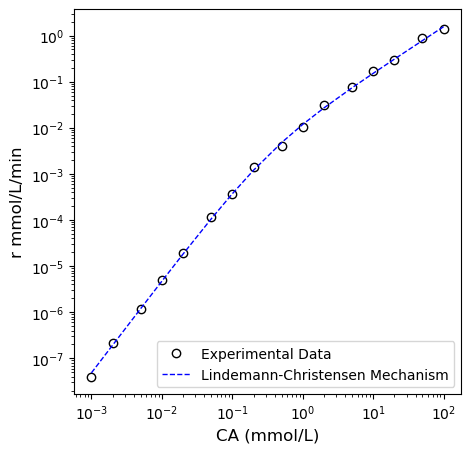

[[ 4.02000000e-08  4.84927224e-08 -8.29272242e-09 -2.06286627e-01]
 [ 2.18000000e-07  1.93373018e-07  2.46269817e-08  1.12967806e-01]
 [ 1.19600000e-06  1.19750822e-06 -1.50821896e-09 -1.26105264e-03]
 [ 5.06000000e-06  4.71798839e-06  3.42011605e-07  6.75912264e-02]
 [ 1.95000000e-05  1.83208443e-05  1.17915568e-06  6.04695219e-02]
 [ 1.16800000e-04  1.05281786e-04  1.15182143e-05  9.86148483e-02]
 [ 3.64000000e-04  3.71282036e-04 -7.28203642e-06 -2.00055946e-02]
 [ 1.37800000e-03  1.20085816e-03  1.77141838e-04  1.28549955e-01]
 [ 4.06000000e-03  4.76763120e-03 -7.07631197e-04 -1.74293398e-01]
 [ 1.04600000e-02  1.18601465e-02 -1.40014646e-03 -1.33857214e-01]
 [ 3.20000000e-02  2.70135041e-02  4.98649592e-03  1.55827997e-01]
 [ 7.50000000e-02  7.36706031e-02  1.32939687e-03  1.77252916e-02]
 [ 1.68000000e-01  1.51943616e-01  1.60563840e-02  9.55737143e-02]
 [ 2.98000000e-01  3.08708707e-01 -1.07087072e-02 -3.59352592e-02]
 [ 9.04000000e-01  7.79189340e-01  1.24810660e-01  1.38064890e

In [26]:
##################################################################################
# Calculate model predictions at the optimal parameter set                       #
##################################################################################

r_mod = r_model(k1_opt, Kprime_opt, CA_exp)

##################################################################################
# Overlay optimal data fit with experimental data                                #
##################################################################################

plt.figure(figsize = (5, 5))
# plt.plot(CA_exp, r_exp, marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', linestyle = 'none', label = 'Experimental Data')
# plt.plot(CA_exp, r_mod, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'Lindemann-Christensen Mechanism')
plt.loglog(CA_exp, r_exp, marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', linestyle = 'none', label = 'Experimental Data')
plt.loglog(CA_exp, r_mod, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'Lindemann-Christensen Mechanism')
plt.xlabel('CA (mmol/L)', fontsize = 12)
plt.ylabel('r mmol/L/min', fontsize = 12)
plt.legend(loc = 'lower right')
plt.show()

##################################################################################
# Next line optionally prints out various residuals; illustrate large vs. small  #
##################################################################################

print(np.vstack([r_exp, r_mod, (r_exp - r_mod), (r_exp - r_mod)/r_exp]).T)